<h1 style='text-align: center;'>MODELING (HYPERPARAMETER TUNING)</h1>

### Import the Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import plotly.offline as pyo
pyo.init_notebook_mode()

import optuna

from sklearn.metrics import f1_score

from pprint import pprint
import os
from joblib import load
from typing import Union, Tuple

### Load the Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/serialized-uti-dataset/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib


In [3]:
X_TRAIN_SCALED, _, Y_TRAIN, _ = load(r"/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib")

In [4]:
X_TRAIN_SCALED

Age     Color  Transparency  Glucose  Protein        pH  \
0     0.684783  0.714286          0.25      0.0     0.00  0.000000   
1     0.336957  0.571429          0.00      0.0     0.25  0.333333   
2     0.163043  0.571429          0.50      0.0     0.50  0.333333   
3     0.173913  0.714286          0.00      0.0     0.00  0.333333   
4     0.510870  0.000000          0.00      0.0     0.00  0.333333   
...        ...       ...           ...      ...      ...       ...   
1889  0.076087  0.571429          0.50      0.0     0.00  0.268642   
1890  0.706522  0.571429          0.75      0.0     0.00  0.368328   
1891  0.000000  0.714286          0.50      0.0     0.25  0.485673   
1892  0.228261  0.571429          0.00      0.0     0.00  0.346820   
1893  0.500000  0.285714          0.50      0.0     0.25  0.333333   

      Specific Gravity       WBC       RBC  Epithelial Cells  Mucous Threads  \
0             0.800000  0.333333  0.000000          0.666667        0.333333   
1             0.800000  0.000000  0.000000          0.166667        0.666667   
2             0.800000  0.083333  0.000000          0.333333        0.666667   
3             0.200000  0.083333  0.000000          0.666667        0.166667   
4             0.200000  0.000000  0.000000          0.166667        0.166667   
...                ...       ...       ...               ...             ...   
1889          0.800000  0.833333  0.000000          0.166667        0.000000   
1890          0.641994  0.833333  0.000000          0.333333        0.000000   
1891          0.756257  0.833333  0.083333          0.166667        0.166667   
1892          0.367632  0.666667  0.000000          0.333333        0.000000   
1893          0.638808  0.750000  0.000000          0.666667        0.333333   

      Amorphous Urates  Bacteria  FEMALE  
0             0.166667       0.6    True  
1             0.000000       0.0   False  
2             0.000000       0.6    True  
3             0.000000       0.0    True  
4             0.000000       0.0   False  
...                ...       ...     ...  
1889          0.333333       1.0    True  
1890          0.000000       1.0    True  
1891          0.166667       0.6    True  
1892          0.000000       0.8    True  
1893          0.166667       0.8    True  

[1894 rows x 14 columns]

In [5]:
Y_TRAIN

0       0
1       0
2       0
3       0
4       0
       ..
1889    1
1890    1
1891    1
1892    1
1893    1
Name: Diagnosis, Length: 1894, dtype: int64

### Splitting the Train Set for Validation Set

In [6]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_TRAIN_SCALED, 
                                                                    Y_TRAIN, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = Y_TRAIN)

### Hyperparameter Tuning

In [7]:
def show_study_summary(study: optuna.study.Study) -> None:
    """
        Display a summary of the optimization study.

        Parameters
        ----------
        study : optuna.study.Study
            The optimization study to summarize.

        Returns
        -------
        None
            This function does not return any values. It displays information and plots.
    """
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)
    parallel_coordinate_plot = optuna.visualization.plot_parallel_coordinate(study)

    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})
    parallel_coordinate_plot.update_layout({"height": 600})

    optimization_history_plot.show()
    param_importances_plot.show()
    parallel_coordinate_plot.show()

### Logistic Regression

In [8]:
def logreg_objective(trial: optuna.study.Study) -> float:
    """
        Objective function for optimizing logistic regression hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            A single optimization trial.

        Returns
        ----------
        float
            F1 score obtained using the specified hyperparameters.
    """
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000)

    LOGREG.fit(X_train_val, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_test_val)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning")

LOGREG_STUDY.optimize(logreg_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-12-04 07:33:47,339] A new study created in memory with name: logreg_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:33:47,474] Trial 0 finished with value: 0.9715762273901808 and parameters: {'tol': 1.0518603242800742e-05, 'C': 0.7298166153556652, 'threshold': 0.5799524970024359}. Best is trial 0 with value: 0.9715762273901808.
[I 2023-12-04 07:33:47,518] Trial 1 finished with value: 0.8672566371681417 and parameters: {'tol': 1.3387944751824363e-06, 'C': 0.7705782204969808, 'threshold': 0.8543000263183896}. Best is trial 0 with value: 0.9715762273901808.
[I 2023-12-04 07:33:47,570] Trial 2 finished with value: 0.9690721649484536 and parameters: {'tol': 0.0007453482638327221, 'C': 0.8541785209483468, 'threshold': 0.5389034817794689}. Best is trial 0 with value: 0.9715762273901808.
[I 2023-12-04 07:33:47,610] Trial 3 finished with value: 0.931129476584022 and parameters: {'tol': 0.007856309586916575, 'C': 0.6202075238637257, 'threshold': 0.7354076007870923}. Best is trial 0 with value: 0.9715762273901808.
[I 2023-12-04 07:33:47,701] Trial 4 finished with value: 0.8705882352941177 and 

Best Hyperparameters
{'C': 0.8366487173026492,
 'threshold': 0.6050197430407676,
 'tol': 0.00038484339850529674}

Accuracy for the Best Hyperparameters
0.9791666666666667


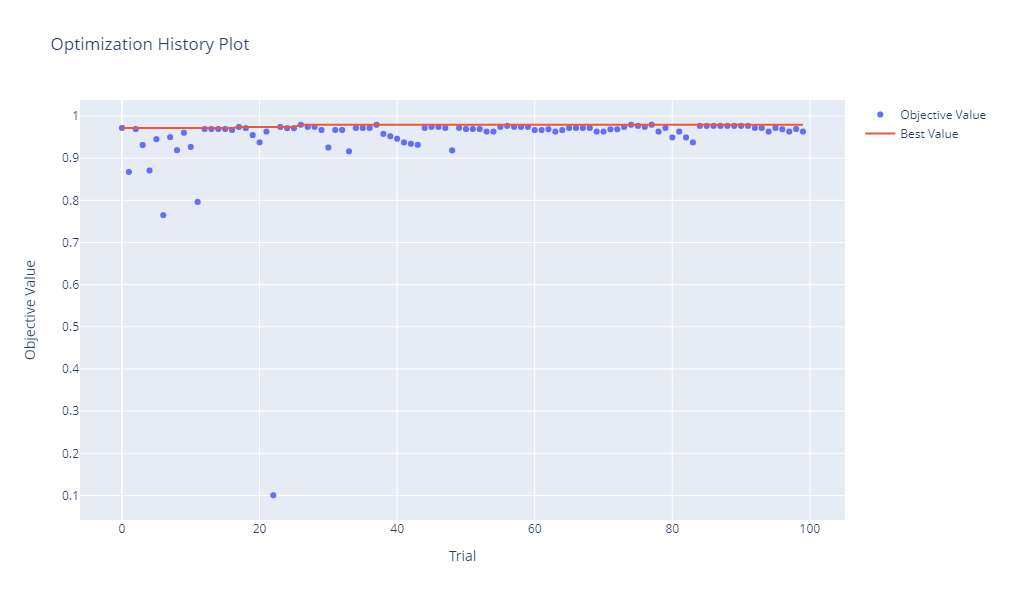

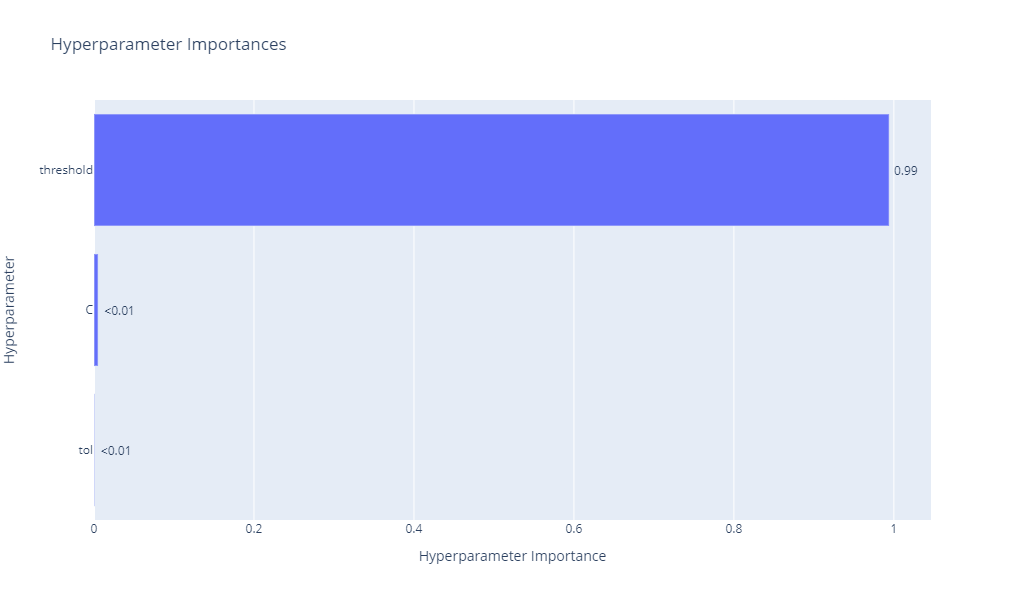

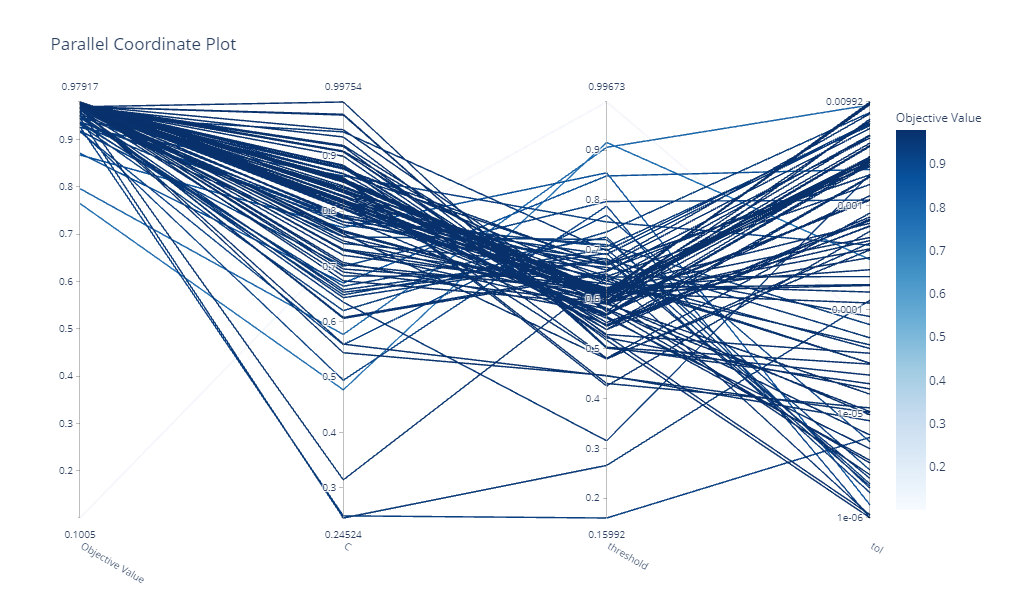

In [9]:
show_study_summary(LOGREG_STUDY)

### Random Forest

In [10]:
def forest_objective(trial: optuna.study.Study)-> float:
    """
        Objective function for optimizing random forest hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            A single optimization trial.

        Returns
        ----------
        float
            F1 score obtained using the specified hyperparameters.
    """
    PARAMS = {
        "n_estimators": trial.suggest_int('n_estimators', 20, 150),
        "max_depth": trial.suggest_int('max_depth', 10, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None, 2]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    }

    RANDOM_FOREST = RandomForestClassifier(**PARAMS)

    RANDOM_FOREST.fit(X_train_val, y_train_val)

    YHAT = RANDOM_FOREST.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

RAND_FOREST_STUDY = optuna.create_study(direction="maximize", study_name="forest_tuning")

RAND_FOREST_STUDY.optimize(forest_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-12-04 07:33:57,513] A new study created in memory with name: forest_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:33:58,256] Trial 1 finished with value: 0.9973614775725593 and parameters: {'n_estimators': 51, 'max_depth': 14, 'max_features': None, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.9973614775725593.
[I 2023-12-04 07:33:58,439] Trial 2 finished with value: 0.9973614775725593 and parameters: {'n_estimators': 60, 'max_depth': 18, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9973614775725593.
[I 2023-12-04 07:33:58,565] Trial 3 finished with value: 0.9947089947089947 and parameters: {'n_estimators': 73, 'max_depth': 26, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.9973614775725593.
[I 2023-12-04 07:33:59,054] Trial 6 finished with value: 0.9947089947089947 and parameters: {'n_estimators': 38, 'max_depth': 25, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.9973614775725593.
[I 2023-12-04 07:33:59,202] Trial 0 finished with value: 0.9973614775725593 and parameters: {'n

Best Hyperparameters
{'criterion': 'log_loss',
 'max_depth': 14,
 'max_features': None,
 'n_estimators': 51}

Accuracy for the Best Hyperparameters
0.9973614775725593


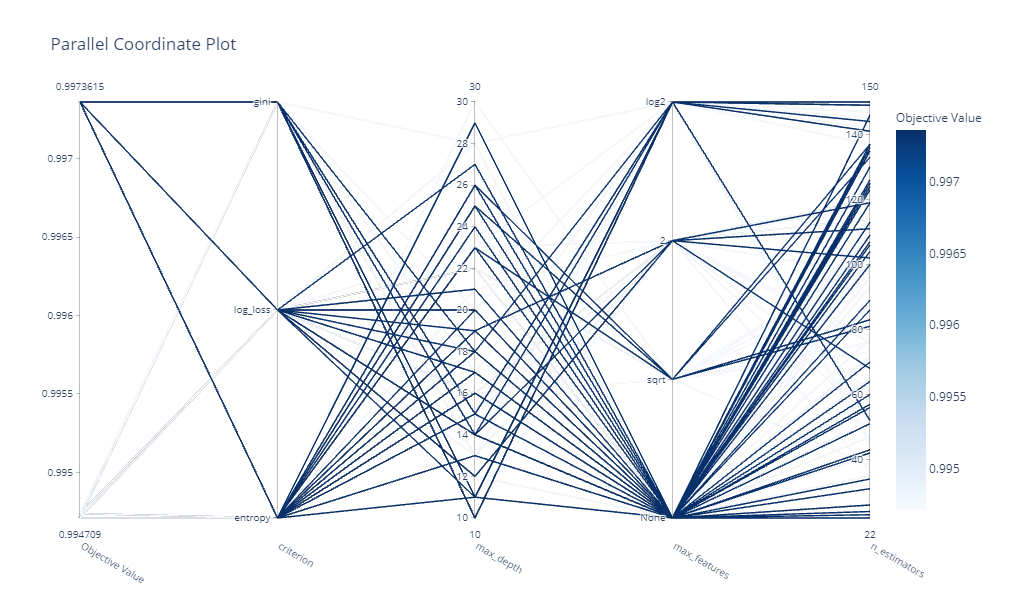

In [11]:
show_study_summary(RAND_FOREST_STUDY)

### Support Vector Machine


In [12]:
def SVC_objective(trial: optuna.study.Study) -> float:
    """
        Objective function for optimizing Support Vector Machine (SVM) hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            A single optimization trial.

        Returns
        ----------
        float
            F1 score obtained using the specified hyperparameters.
    """
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS)

    SVC_MODEL.fit(X_train_val, y_train_val)

    YHAT = SVC_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning")

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-12-04 07:34:33,810] A new study created in memory with name: SVM_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:34:33,926] Trial 3 finished with value: 0.9792746113989638 and parameters: {'C': 0.17906315595930283, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9792746113989638.
[I 2023-12-04 07:34:33,943] Trial 1 finished with value: 0.9792746113989638 and parameters: {'C': 0.12977845136093374, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9792746113989638.
[I 2023-12-04 07:34:34,010] Trial 4 finished with value: 0.9767441860465117 and parameters: {'C': 0.11579223559476569, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9792746113989638.
[I 2023-12-04 07:34:34,035] Trial 0 finished with value: 0.4987012987012987 and parameters: {'C': 0.8544761764579051, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.9792746113989638.
[I 2023-12-04 07:34:34,056] Trial 2 finished with value: 0.5025906735751294 and parameters: {'C': 0.6958949941024701, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.9792746113989638.
[I 2023-12-04 07:34:34,085] Trial 6 finished with value: 0.9947368421

Best Hyperparameters
{'C': 0.4723117590308783, 'kernel': 'poly'}

Accuracy for the Best Hyperparameters
0.9973614775725593


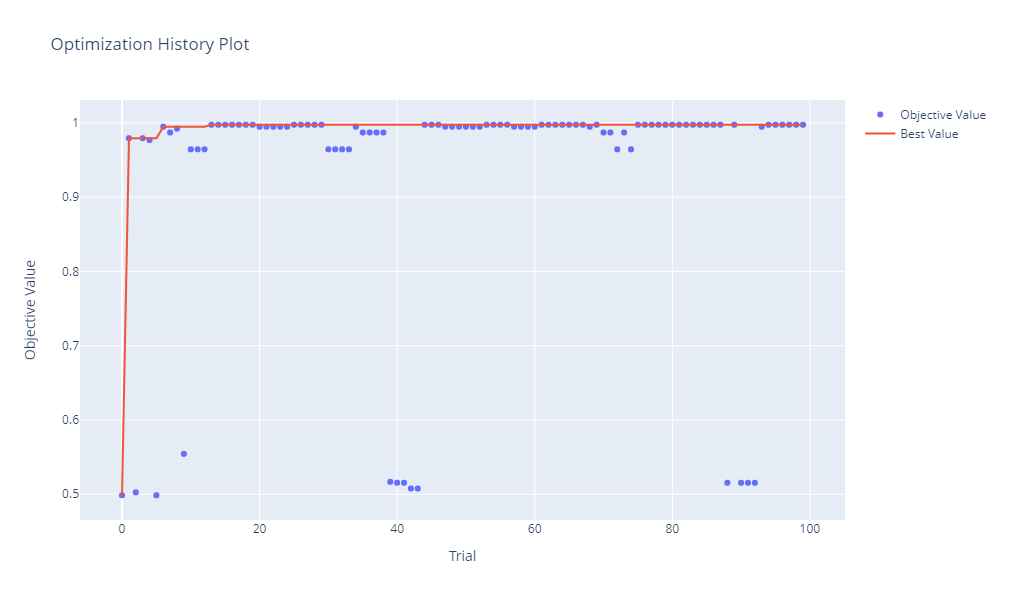

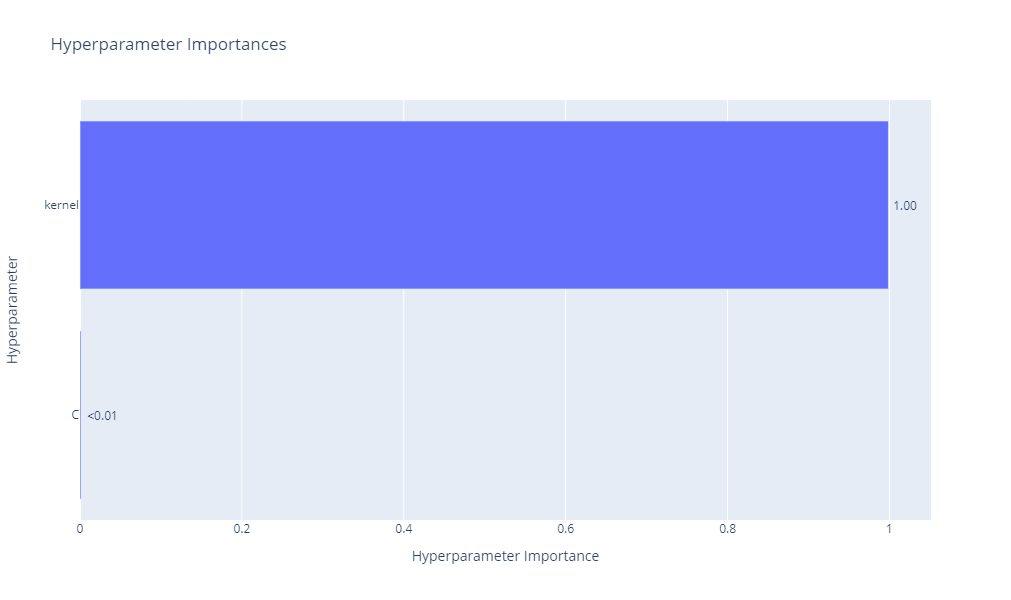

In [13]:
show_study_summary(SVM_SVC_STUDY)

### XGBoost

In [14]:
def XGB_objective(trial: optuna.study.Study) -> float:
    """
        Objective function for optimizing XGBoost hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            A single optimization trial.

        Returns
        ----------
        float
            F1 score obtained using the specified hyperparameters.
    """
    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS)

    XGB_model.fit(X_train_val, y_train_val)

    YHAT = XGB_model.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning")

XGB_STUDY.optimize(XGB_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-12-04 07:34:37,572] A new study created in memory with name: XGB_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:34:38,053] Trial 0 finished with value: 0.9947368421052631 and parameters: {'reg_alpha': 0.6137974741847214, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.002082116340876489}. Best is trial 0 with value: 0.9947368421052631.
[I 2023-12-04 07:34:39,023] Trial 3 finished with value: 0.9947368421052631 and parameters: {'reg_alpha': 0.6205621134395558, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.0005245134930622135}. Best is trial 0 with value: 0.9947368421052631.
[I 2023-12-04 07:34:39,592] Trial 1 finished with value: 0.9947368421052631 and parameters: {'reg_alpha': 0.39348222554398793, 'n_estimators': 550, 'max_depth': 9, 'learning_rate': 0.0005522458007466366}. Best is trial 0 with value: 0.9947368421052631.
[I 2023-12-04 07:34:40,524] Trial 2 finished with value: 0.9973614775725593 and parameters: {'reg_alpha': 0.6884590873817132, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01755128314752933}. Best is trial 2 with value: 0.99736147757

Best Hyperparameters
{'learning_rate': 0.01755128314752933,
 'max_depth': 8,
 'n_estimators': 1000,
 'reg_alpha': 0.6884590873817132}

Accuracy for the Best Hyperparameters
0.9973614775725593


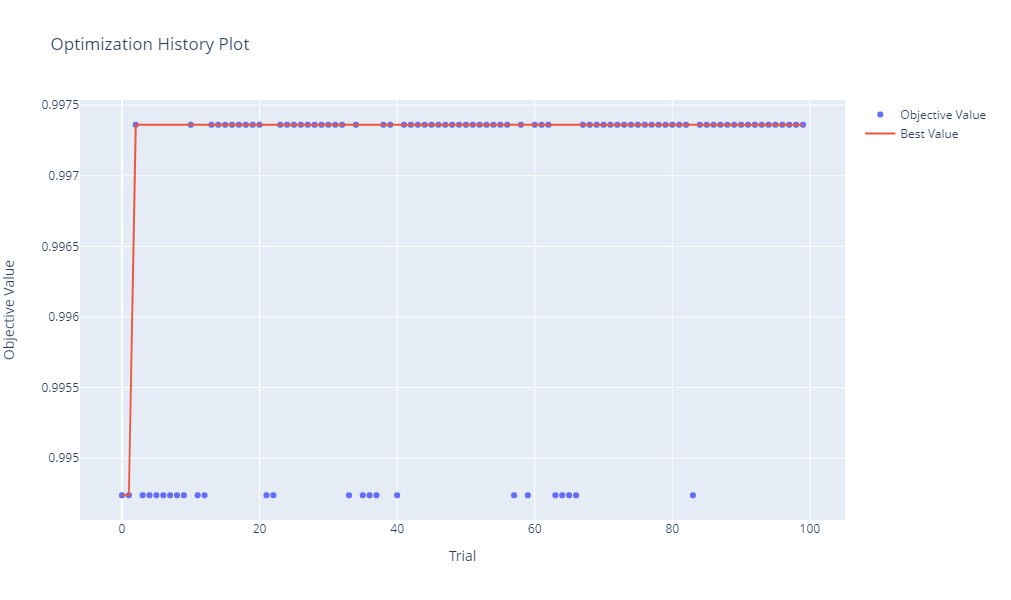

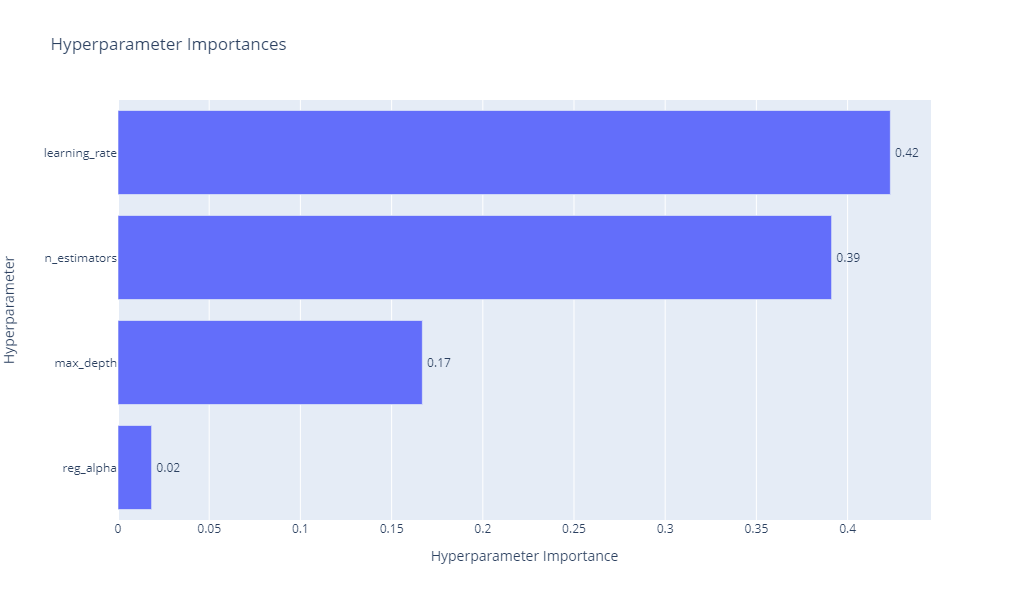

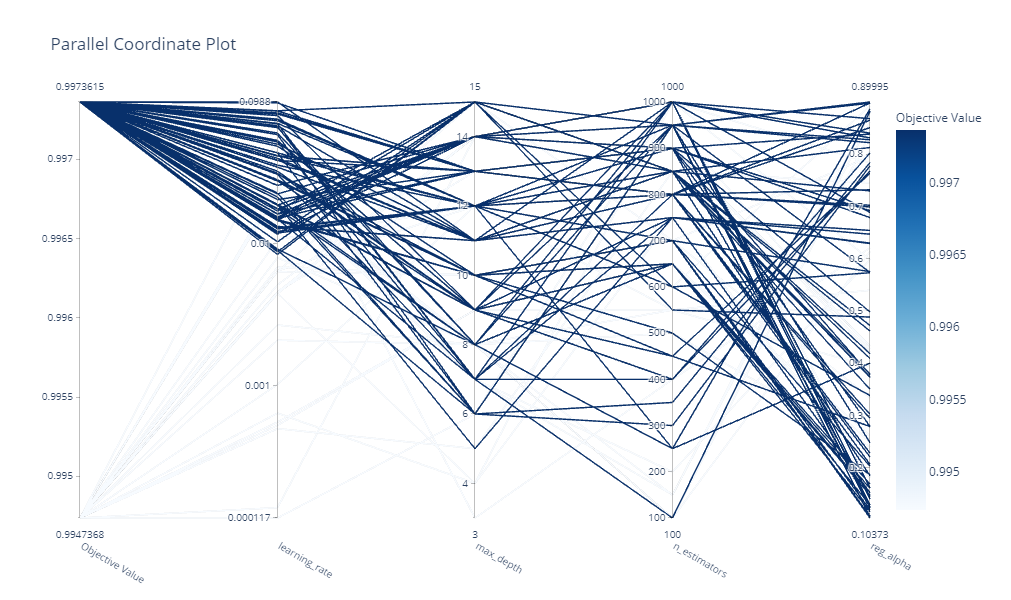

In [15]:
show_study_summary(XGB_STUDY)

### Light GBM

In [16]:
def lightgmb_objective(trial: optuna.study.Study) -> float:
    """
        Objective function for optimizing LightGBM hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            A single optimization trial.

        Returns
        ----------
        float
            F1 score obtained using the specified hyperparameters.
    """
    PARAMS = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS)
    
    LGMB_MODEL.fit(X_train_val, y_train_val) 
    
    YHAT = LGMB_MODEL.predict(X_test_val)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning")

LGBM_STUDY.optimize(lightgmb_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-12-04 07:35:33,902] A new study created in memory with name: lgbm_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:35:34,702] Trial 2 finished with value: 0.9973614775725593 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.030345137568686124, 'reg_alpha': 0.11361949166171802}. Best is trial 2 with value: 0.9973614775725593.
[I 2023-12-04 07:35:34,709] Trial 3 finished with value: 0.9947368421052631 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0019249677725489528, 'reg_alpha': 0.2574300546671844}. Best is trial 2 with value: 0.9973614775725593.
[I 2023-12-04 07:35:34,855] Trial 1 finished with value: 0.9947368421052631 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'n_estimators': 350, 'max_depth': -1, 'learning_rate': 0.003137322292624711, 'reg_alpha': 0.67225064248585}. Best is trial 2 with value: 0.9973614775725593.
[I 2023-12-04 07:35:35,017] Trial 0 finished with value: 0.9947368421052631 and parameters: {'boosting_type': 'dart',

Best Hyperparameters
{'boosting_type': 'gbdt',
 'learning_rate': 0.030345137568686124,
 'max_depth': 3,
 'n_estimators': 350,
 'num_leaves': 40,
 'reg_alpha': 0.11361949166171802}

Accuracy for the Best Hyperparameters
0.9973614775725593


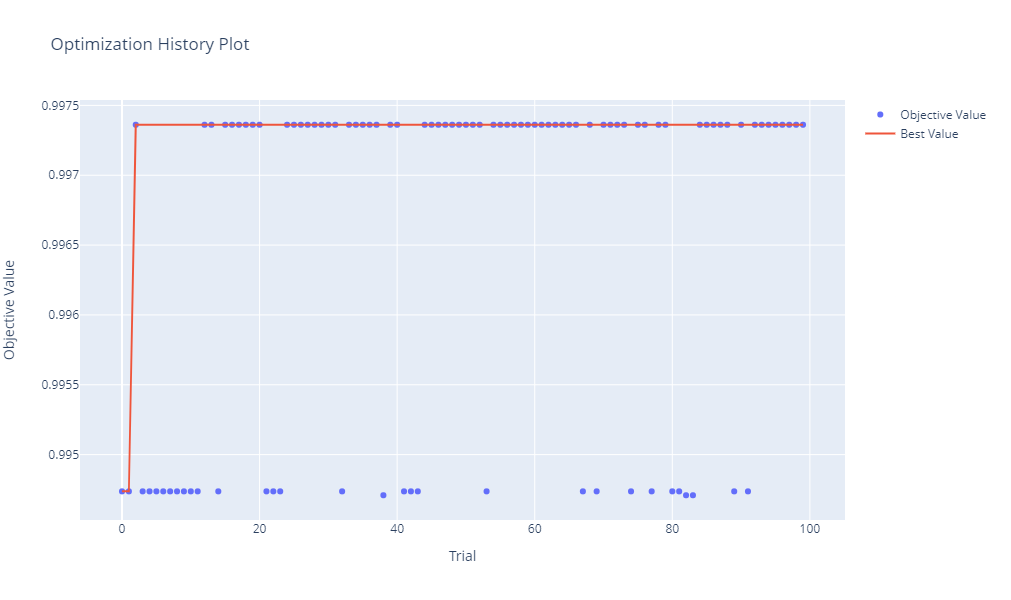

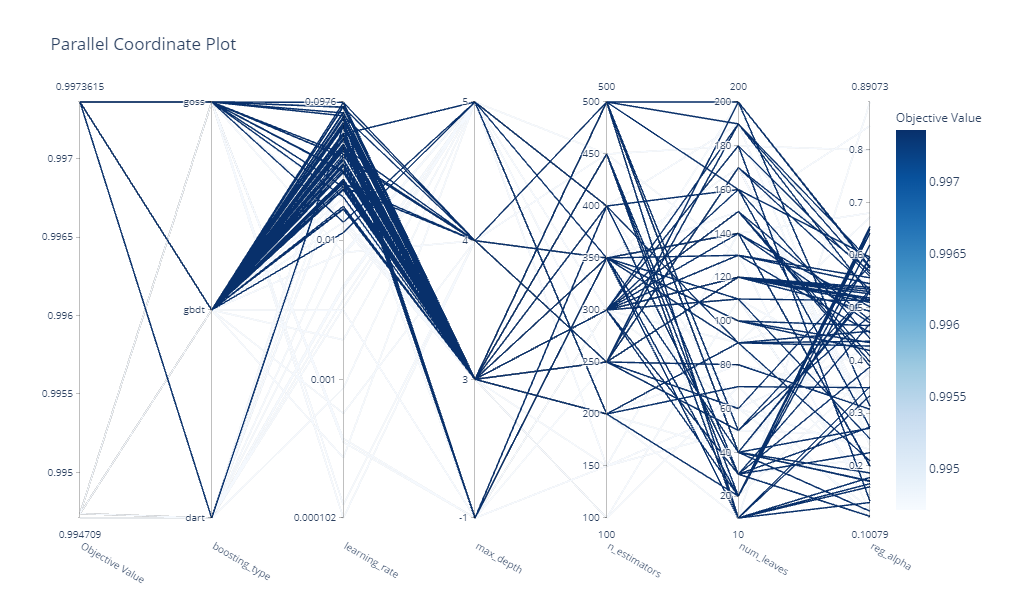

In [17]:
show_study_summary(LGBM_STUDY)

### ANN: Multi-layer Perceptron

#### Load the data using Pytorch

In [18]:
class UTIDataset(Dataset):
    def __init__(self, df, transform=None):
        """
            Custom PyTorch dataset for the UTI dataset.

            Parameters
            ----------
            df : pandas.DataFrame
                The dataset as a DataFrame.
            transform : callable, optional
                A function to apply transformations on input features and labels, default is None.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """
            Get the length of the dataset.

            Returns
            ----------
            int
                The number of samples in the dataset.

        """
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[Union[torch.Tensor, torch.Tensor]]:
        """
            Get a specific sample from the dataset.

            Parameters
            ----------
            idx : int
                Index of the sample to retrieve.

            Returns
            ----------
            tuple
                A tuple containing the input features and labels.

        """
        # Extract features and labels from the DataFrame
        x = self.df.iloc[idx, :-1].values.astype("float32").reshape((self.df.columns.__len__() - 1, 1))
        y = self.df.iloc[idx, -1:].values.astype("long").reshape((1, 1))

        # Apply transformations if provided
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

#### Transformation

In [19]:
# Define a transformation using torchvision's ToTensor()
TRANSFORMER = transforms.ToTensor()

# Reset indices of the training set
X_TRAIN_SCALED_RESET = X_TRAIN_SCALED.reset_index(drop=True)
Y_TRAIN_RESET = Y_TRAIN.reset_index(drop=True)

# Concatenate scaled features and labels into a single DataFrame
DF = pd.concat([X_TRAIN_SCALED_RESET, Y_TRAIN_RESET], axis=1)

# Create an instance of the UTIDataset with the training dataset and the specified transform
DATA = UTIDataset(DF, TRANSFORMER)

#### Split the data

In [20]:
TRAIN_VAL_SPLIT_RATIO = [0.8, 0, 0.2]
TRAIN_SET_TORCH, _, VAL_SET_TORCH = random_split(DATA, TRAIN_VAL_SPLIT_RATIO)

In [21]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define batch size
BATCH_SIZE = 16

# Calculate the size of the training dataset
DATA_SIZE = len(X_TRAIN_SCALED_RESET)

# Define indices for training and validation sets based on the split ratio
TRAIN_INDICES = list(range(int(DATA_SIZE - (DATA_SIZE * TRAIN_VAL_SPLIT_RATIO[2]))))
VAL_INDICES = list(range(int(DATA_SIZE - (DATA_SIZE * TRAIN_VAL_SPLIT_RATIO[0]))))

# Create SubsetRandomSampler instances for training and validation sets
TRAIN_SAMPLER = SubsetRandomSampler(TRAIN_INDICES)
VAL_SAMPLER = SubsetRandomSampler(VAL_INDICES)

# Create DataLoader instances for training and validation sets
TRAIN_LOADER = DataLoader(TRAIN_SET_TORCH, batch_size=BATCH_SIZE, sampler=TRAIN_SAMPLER)
VAL_LOADER = DataLoader(VAL_SET_TORCH, batch_size=BATCH_SIZE, sampler=VAL_SAMPLER)

#### MLP Architecture

<img src="../assets/MLP_ARCHITECTURE.jpg">

In [22]:
class ClassifierNN(nn.Module):
    """
        Neural network classifier.

        Parameters
        ----------
        activation_function : torch.nn.Module
            The activation function to be used in the network.

        Attributes
        ----------
        activation_function : torch.nn.Module
            The activation function for the network.
        fcn1 : torch.nn.Linear
            The first fully connected layer with input size 14 and output size 32.
        fcn2 : torch.nn.Linear
            The second fully connected layer with input size 32 and output size 64.
        fcn3 : torch.nn.Linear
            The third fully connected layer with input size 64 and output size 128.
        fcn4 : torch.nn.Linear
            The fourth fully connected layer with input size 128 and output size 2.

        Methods
        -------
        forward(x)
            Forward pass of the neural network.
    """

    def __init__(self, activation_function):
        super().__init__()

        self.activation_function = activation_function

        # Define fully connected layers
        self.fcn1 = nn.Linear(14, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
            Forward pass of the neural network.

            Parameters
            ----------
            x : torch.Tensor
                Input tensor with shape (-1, 14).

            Returns
            -------
            torch.Tensor
                Output tensor after the forward pass.
        """
        x = x.view(-1, 14)

        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))

        x = self.fcn4(x)

        return x

In [23]:
# Check if CUDA (GPU) is available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device
print(DEVICE)

cuda


#### MLP TUNING

In [24]:
def tune_NN(trial: optuna.Trial, train_loader_: torch.utils.data.DataLoader, val_loader_: torch.utils.data.DataLoader) -> float:
    """
        Tune a Convolutional Neural Network (CNN) using various hyperparameters.

        Parameters
        ----------
        trial : optuna.Trial
            An Optuna trial object used for hyperparameter optimization.

        train_loader_ : torch.utils.data.DataLoader
            DataLoader for the training dataset.

        val_loader_ : torch.utils.data.DataLoader
            DataLoader for the validation dataset.

        Returns
        -------
        float
            The accuracy of the tuned CNN model on the validation dataset.

        Notes
        -----
        This function performs hyperparameter optimization for a CNN model using the Optuna library.

        The hyperparameters that can be optimized are:
        - Kernel size for convolutional layers
        - Choice of optimizer (SGD, Adam, or RMSprop)
        - Activation functions (ReLU, Leaky ReLU, or Tanh)
        - Learning rate
        - Number of training epochs

        The CNN model is trained and tuned using the specified hyperparameters, and its accuracy on the
        validation dataset is returned.

        Examples
        --------
        >>> import optuna
        >>> study = optuna.create_study(direction='maximize')
        >>> study.optimize(tune_CNN, n_trials=10, args=(train_loader, val_loader))
        >>> best_trial = study.best_trial
        >>> best_accuracy = best_trial.value
        >>> best_PARAMS = best_trial.PARAMS
        >>> print(f"Best accuracy: {best_accuracy}")
        >>> print(f"Best hyperparameters: {best_PARAMS}")
    """
    global DEVICE

    OPTIMIZERS_ = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    ACTIVATION_FUCTION = trial.suggest_categorical("activation function", [F.relu, F.leaky_relu, F.tanh])
    LEARNING_RATE = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    EPOCHS = trial.suggest_int("epochs", 10, 50)

    NN_model = ClassifierNN(ACTIVATION_FUCTION)

    NN_model = NN_model.to(DEVICE)

    CRITERION = nn.CrossEntropyLoss()
 
    if OPTIMIZERS_ == "SGD":
        optimizer = optim.SGD(NN_model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZERS_ == "Adam":
        optimizer = optim.Adam(NN_model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZERS_ == "RMSprop":
        optimizer = optim.RMSprop(NN_model.parameters(), lr=LEARNING_RATE)

    for _ in range(EPOCHS):
        running_loss = 0.0

        for x_train, y_train in train_loader_:
            x_train = x_train.to(DEVICE)
            y_train = y_train.to(DEVICE)

            optimizer.zero_grad()
            OUTPUTS = NN_model(x_train)
            
            y_train = y_train.flatten()

            loss = CRITERION(OUTPUTS, y_train)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader_:
            val_X = val_X.to(DEVICE)
            val_y = val_y.to(DEVICE)

            OUTPUTS = NN_model(val_X)

            _, YHAT = torch.max(OUTPUTS.data, 1)

            true_labels.extend([arr.flatten()[0] for arr in val_y.cpu().numpy()])
            predicted_labels.extend(YHAT.cpu().numpy())

    F1_SCORE_ = f1_score(true_labels, predicted_labels)

    torch.cuda.empty_cache()

    return F1_SCORE_

In [25]:
# Create an Optuna study for hyperparameter optimization
MLP_STUDY = optuna.create_study(direction="maximize")

# Define the parameters for the optimization study
PARAMS = {"train_loader_": TRAIN_LOADER,
          "val_loader_": VAL_LOADER}

# Optimize the objective function using Optuna
MLP_STUDY.optimize(lambda trial: tune_NN(trial, **PARAMS),
                   n_trials=100,
                   n_jobs=-1,  # Parallelize trials using all available CPUs
                   show_progress_bar=True)

[I 2023-12-04 07:36:00,057] A new study created in memory with name: no-name-3dee5708-36a0-46d0-be32-67be64900916


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-04 07:37:13,646] Trial 0 finished with value: 0.0 and parameters: {'optimizer': 'SGD', 'activation function': <function relu at 0x7c9028e6d900>, 'learning_rate': 8.142745945920846e-05, 'epochs': 35}. Best is trial 0 with value: 0.0.
[I 2023-12-04 07:38:00,174] Trial 1 finished with value: 0.9774436090225564 and parameters: {'optimizer': 'RMSprop', 'activation function': <function relu at 0x7c9028e6d900>, 'learning_rate': 5.838327017460161e-05, 'epochs': 49}. Best is trial 1 with value: 0.9774436090225564.
[I 2023-12-04 07:38:08,417] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'SGD', 'activation function': <function relu at 0x7c9028e6d900>, 'learning_rate': 0.00018093538632834384, 'epochs': 28}. Best is trial 1 with value: 0.9774436090225564.
[I 2023-12-04 07:38:26,676] Trial 2 finished with value: 0.9874055415617129 and parameters: {'optimizer': 'Adam', 'activation function': <function relu at 0x7c9028e6d900>, 'learning_rate': 0.009003235168783614, 'epochs

Best Hyperparameters
{'activation function': <function relu at 0x7c9028e6d900>,
 'epochs': 37,
 'learning_rate': 0.0027947441158155235,
 'optimizer': 'Adam'}

Accuracy for the Best Hyperparameters
0.9949238578680203


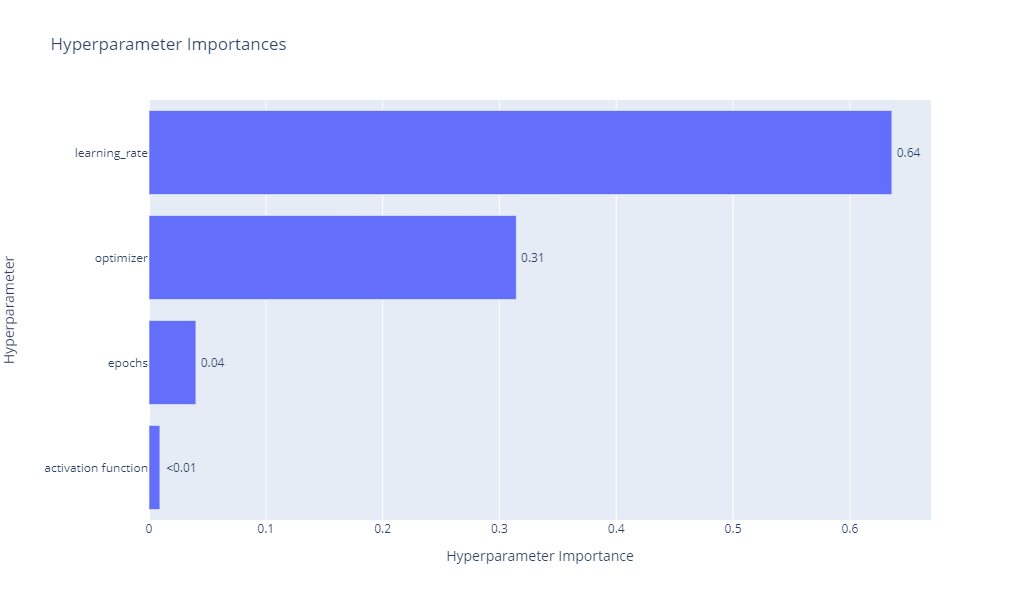

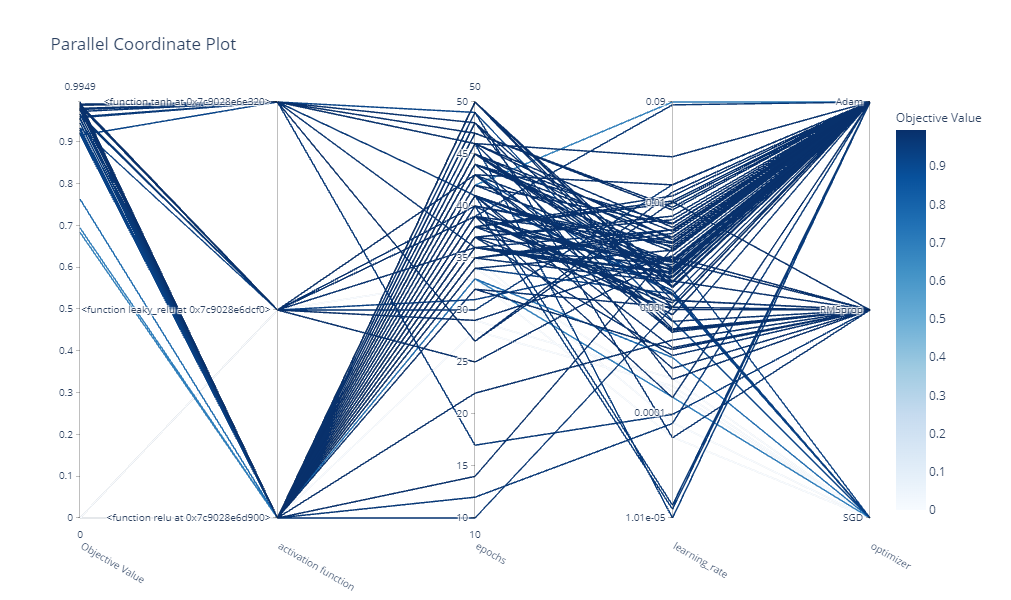

In [26]:
show_study_summary(MLP_STUDY)